# Main Goals

>  The main goal of this notebook is the comprehensive selection, tuning, and training of the best regression models for predicting goal counts. Models will be used to generate predictions for the top scorers for the current 2025/26 season. The analysis and forecasts are leaded in the context of the current league situation, after the 11th matchweek of the Premier League.

***3/3***


In [ ]:
!pip install optuna-integration[sklearn]
!pip install -U optuna optuna-integration
!pip install -U optuna optuna-integration xgboost
!pip install catboost

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import statsmodels.formula.api as smf
import statsmodels.api as sm

from optuna.distributions import FloatDistribution, IntDistribution, CategoricalDistribution
from optuna.integration import OptunaSearchCV
from catboost import CatBoostRegressor

from optuna.pruners import MedianPruner
from optuna.integration.xgboost import XGBoostPruningCallback
from lightgbm import LGBMRegressor
from sklearn.svm import SVR

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import warnings
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")


warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [ ]:
path="https://raw.githubusercontent.com/ruus77/Portfolio/refs/heads/main/PL_best_scorer/PL_1920_2526.csv"
df = pd.read_csv(path)
df = df.sort_values(by=["team", "season"])
df.drop(columns="Unnamed: 0", inplace=True)
df.head()

,league,season,team,player,league_id,season_id,team_id,player_id,position,matches,minutes,goals,xg,np_goals,np_xg,assists,xa,shots,key_passes,yellow_cards,red_cards,xg_chain,xg_buildup,previous_season_position,is_in_europe,lagged_mpm_1,lagged_fmp_1,lagged_xg_perf_1,lagged_npxg_perf_1,lagged_xg_per_shot_1,lagged_penalty_taker_1,lagged_g90_1,lagged_a90_1,lagged_ga90_1,lagged_xg90_1,lagged_xa90_1,lagged_goals_1,lagged_mpm_2,lagged_fmp_2,lagged_xg_perf_2,lagged_npxg_perf_2,lagged_xg_per_shot_2,lagged_penalty_taker_2,lagged_g90_2,lagged_a90_2,lagged_ga90_2,lagged_xg90_2,lagged_xa90_2,lagged_goals_2,main_pos,position_1,position_2,position_3,position_4
85,ENG-Premier League,1920,Arsenal,ainsley maitland-niles,1,2019,83,1750,D S,20,1372,0.0,0.508408,0,0.508408,2,1.646097,4,11,4,1,5.156502,3.567148,5.0,1.0,60.826087,7.688889,-0.401947,-0.401947,0.038172,0.0,0.000000,0.000000,0.000000,0.013581,0.009722,0.0,60.826087,7.688889,-0.401947,-0.401947,0.038172,0.0,0.000000,0.000000,0.000000,0.013581,0.009722,0.0,1,1,0,0,0
137,ENG-Premier League,1920,Arsenal,alexandre lacazette,1,2019,83,3277,F S,30,1890,10.0,8.664644,10,8.664644,4,3.342293,52,24,8,0,12.061310,2.505634,5.0,1.0,31.547101,5.322222,-1.946718,-1.990343,0.125597,0.0,0.149728,0.000000,0.256184,0.302738,0.065931,1.0,31.547101,5.322222,-1.946718,-1.990343,0.125597,0.0,0.149728,0.000000,0.256184,0.302738,0.065931,1.0,3,0,0,1,0
421,ENG-Premier League,1920,Arsenal,bernd leno,1,2019,83,181,GK,30,2649,0.0,0.000000,0,0.000000,0,0.000000,0,0,2,0,4.038204,4.038204,5.0,1.0,90.000000,4.250000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,90.000000,4.250000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0,0,0,0
502,ENG-Premier League,1920,Arsenal,bukayo saka,1,2019,83,7322,D F M S,26,1769,1.0,1.142438,1,1.142438,5,3.680353,13,21,6,0,7.812512,5.022922,5.0,1.0,51.383333,12.005556,-1.373554,-1.373554,0.071989,0.0,0.050042,0.082329,0.175781,0.096436,0.094520,1.0,51.383333,12.005556,-1.373554,-1.373554,0.071989,0.0,0.050042,0.082329,0.175781,0.096436,0.094520,1.0,3,0,0,1,0
534,ENG-Premier League,1920,Arsenal,calum chambers,1,2019,83,508,D S,14,1102,1.0,0.632950,1,0.632950,1,2.241444,12,7,5,0,4.406148,3.210470,5.0,1.0,60.826087,7.688889,-0.401947,-0.401947,0.038172,0.0,0.000000,0.000000,0.000000,0.013581,0.009722,0.0,60.826087,7.688889,-0.401947,-0.401947,0.038172,0.0,0.000000,0.000000,0.000000,0.013581,0.009722,0.0,1,1,0,0,0


In [ ]:
teams_names = list(df.team.unique())

In [ ]:
teams_endocer = LabelEncoder()
teams_endocer.fit(teams_names)

LabelEncoder()

In [ ]:
df["team_labeled"] = teams_endocer.transform(df["team"])
df["goals_trend"] = df.lagged_goals_1 - df.lagged_goals_2

In [ ]:
df = df[df.goals > 2]

In [ ]:
cols_to_drop = ["season", "team", "player", "position", "main_pos",
                "season_id", "np_goals", "team_id", "player_id", "league", "league_id"]


In [ ]:
leaking_cols = ["matches", "minutes", "xg", "np_goals", "np_xg", "assists", "xa", "shots", "key_passes", "yellow_cards", "red_cards", "xg_chain", "xg_buildup"]

# Modeling Preparation

Data was split into training and testing sets. Two feature sets (`datasets`) were created based on correlation analysis. This was done to find features correlated with the target (`goals`) and to manage **Multicollinearity**, where features are highly correlated with each other.

* `Case 1` : The 12 features with the highest absolute correlation to `goals` were selected. This method ignores multicollinearity.
* `Case 2` (Reduced Multicollinearity): Features were selected using the `reduce_multicollinearity` function (threshold `0.7`) to create a set less dependent on each other, which is crucial for linear models.

Following this, the explanatory variables (`features`) and target variable (`target`) were defined. The `datasets`, `X_train`, `X_test`, `y_train`, and `y_test` lists were created based on these two cases. **The training sets included data from the 19/20 to 23/24 seasons, while the test set consisted of data from the 24/25 season.** Finally, `TimeSeriesSplit` (`tscv`) was defined as the cross-validation strategy, which is essential for time-structured data.


On target variable `y` $log(y+1)$ was applied to deal with outliers.

<Axes: >

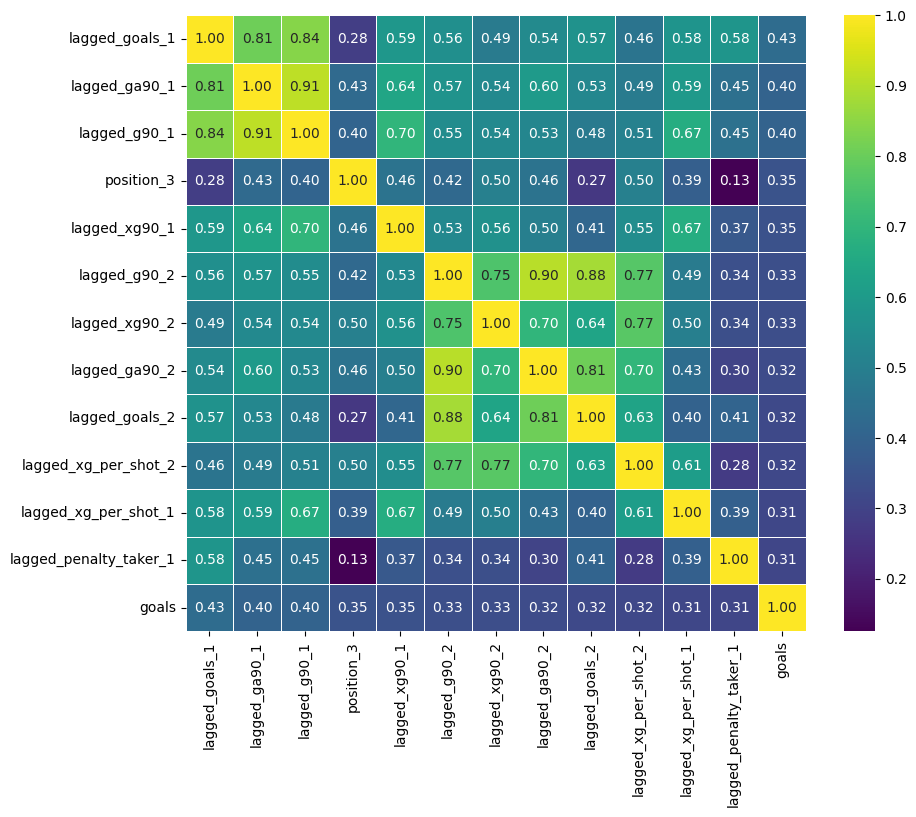

In [ ]:
plt.figure(figsize=(10, 8))
case_1 = list((df.drop(cols_to_drop+leaking_cols, axis=1).corr().goals.apply(np.abs).sort_values(ascending=False).drop("goals").head(12)).index)

sns.heatmap(data=df[case_1+["goals"]].corr(), annot=True, fmt=".2f", cmap="viridis", linewidths=.5)

In [ ]:
def reduce_multicollinearity(df: pd.DataFrame,
                           cols_to_drop: list,
                           target: str,
                           threshold: float):

    features = df.drop(cols_to_drop, axis=1)
    corr_mat = features.corr().abs()
    target_corr = corr_mat[target]

    upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
    high_corr_pairs = upper.stack()[upper.stack() > threshold].index

    to_drop = set()
    for feat1, feat2 in high_corr_pairs:
        if target_corr[feat1] < target_corr[feat2]:
            to_drop.add(feat1)
        else:
            to_drop.add(feat2)

    final_features = set(features.columns) - to_drop - {target}
    return list(final_features)

In [ ]:
case_2 = reduce_multicollinearity(df=df,
                                  cols_to_drop=cols_to_drop+leaking_cols,
                                  target='goals',
                                  threshold=0.6)

case_2

['team_labeled',
 'position_3',
 'goals_trend',
 'lagged_npxg_perf_1',
 'position_1',
 'lagged_fmp_1',
 'position_4',
 'lagged_goals_1',
 'lagged_npxg_perf_2',
 'lagged_penalty_taker_1',
 'lagged_g90_2',
 'previous_season_position']

<Axes: >

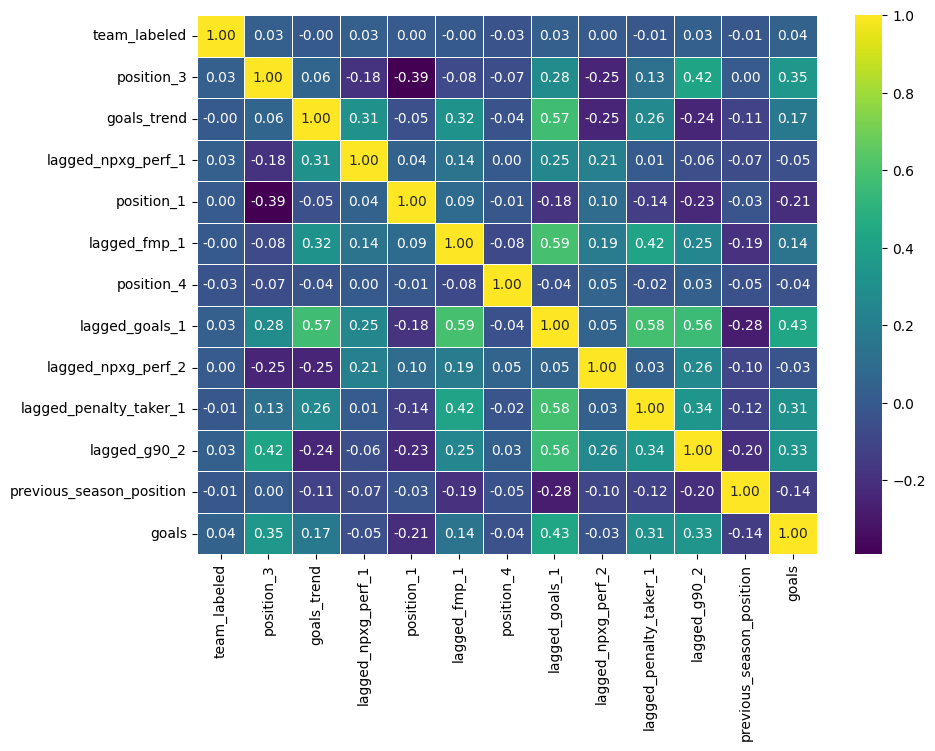

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(data=df[case_2+["goals"]].corr(), annot=True, fmt=".2f", cmap="viridis", linewidths=.5)

In [ ]:
case_3 = list(set(df.columns) - set(cols_to_drop + leaking_cols + ["goals"]))

In [ ]:
df.season.unique()

array([1920, 2021, 2122, 2223, 2324, 2425, 2526])

In [ ]:
train = ~df['season'].isin([2425, 2526])
test = df['season'].isin([2425])


In [ ]:
X_case1 = df[case_1]
X_case2 = df[case_2]
X_case3 = df[case_3]
y = df.goals

train = ~df['season'].isin([2425, 2526])
test = df['season'].isin([2425])

X_case1_train = X_case1[train]
X_case1_test = X_case1[test]


X_case2_train = X_case2[train]
X_case2_test = X_case2[test]


X_case3_train = X_case3[train]
X_case3_test = X_case3[test]

y_train = y[train].apply(np.log1p)
y_test= y[test].apply(np.log1p)

# Model & Tuning Configuration

In this section, all models for the experiment were defined, along with their respective hyperparameter search spaces. A range of models was selected to compare different algorithmic approaches:
>
> * **Linear Models:** A simple `Linear Regression` was included to serve as a baseline. `Ridge` and `Lasso` were included because their built-in regularization is effective at managing multicollinearity and preventing overfitting.
> * **Non-linear & Ensemble Models:** `Support Vector Regression` and `Random Forest` were chosen to test if models that can capture complex, non-linear relationships would perform better.
> * **Boosting Model:** A gradient boosting model was included as the most complex and (potentially) most accurate algorithm.
>
> Finally, dictionaries (`best_estimators`, `best_params`) were initialized. These will be used in the next section to store the winning model, its best parameters, and its performance metrics for each experiment.

In [ ]:
ridge = Ridge()
lasso = Lasso()

lr = LinearRegression()
rf = RandomForestRegressor(random_state=77, n_jobs=-1)
svr = SVR(kernel='rbf')


In [ ]:
cat = CatBoostRegressor(random_state=77, verbose=0)

In [ ]:
scaler = RobustScaler()
poly = PolynomialFeatures()

ridge_pipe = make_pipeline(poly, scaler , ridge)
lasso_pipe = make_pipeline(poly, scaler, lasso)
lr_pipe = make_pipeline(poly, scaler, lr)
svr_pipe = make_pipeline(scaler, svr)

In [ ]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)


In [ ]:
ridge_grid = {
#"polynomialfeatures__degree": IntDistribution(1, 3),
"ridge__alpha": FloatDistribution(30, 100.0, log=True)
}

lasso_grid = {
#"polynomialfeatures__degree": IntDistribution(1, 3),
"lasso__alpha": FloatDistribution(0.001, 10, log=True)
}

lr_grid= {"polynomialfeatures__degree": IntDistribution(1, 3)}

rf_grid = {
    'n_estimators': IntDistribution(100, 700, step=100),
    'max_depth': IntDistribution(10, 50),
    'min_samples_split': IntDistribution(4, 30),
    'max_features': CategoricalDistribution(['log2', 'sqrt'])
}

catboost_grid = {
    'iterations': IntDistribution(100, 500, step=50),
    'learning_rate': FloatDistribution(0.001, 0.05, log=True),
    'depth': IntDistribution(2, 6),
    'l2_leaf_reg': FloatDistribution(0.1, 10.0, log=True),
    'subsample': FloatDistribution(0.3, 1.0),
    'rsm': FloatDistribution(0.1, 0.4),
}


svr_grid = {
    'svr__C': FloatDistribution(0.1, 10.0, log=True)
}

In [ ]:
linear_grids = [ridge_grid, lasso_grid, lr_grid, svr_grid, rf_grid, catboost_grid]


In [ ]:
best_estimators = {
    "model_name" : [],
    "dataset" : [],
    "mse_train" : [],
    "mse_test" : [],
    "mae_train" : [],
    "mae_test" : []


    }
best_params = {
    "model_name" : [],
    "best_params" : [],
    "dataset" : []}

In [ ]:
X_train = [X_case1_train,  X_case2_train]
X_test = [X_case1_test, X_case2_test]
datasets = ["case1", "case2"]

In [ ]:

linear_models = [ridge_pipe, lasso_pipe, lr_pipe, svr_pipe, rf, cat]
linear_models_names = ["ridge", "lasso", "lr", "svr", "rf", "cat"]

In [ ]:
df.isnull().sum().sum()

np.int64(0)

In [ ]:
for dataset, x_train, x_test in tqdm(zip(datasets, X_train, X_test), total = len(datasets)):
  for model_name, model, grid in zip(linear_models_names, linear_models, linear_grids):

      params_search = OptunaSearchCV(
        estimator=model,
        param_distributions=grid,
        n_trials=50,
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_jobs=-1,

      )
      params_search.fit(x_train, y_train)
      best_model = params_search.best_estimator_
      best_params_dict = params_search.best_params_
      y_pred = best_model.predict(x_test)
      y_pred_train = best_model.predict(x_train)

      mse_train = mean_squared_error(y_pred_train, y_train)
      mse_test = mean_squared_error(y_pred, y_test)

      mae_train = mean_absolute_error(y_pred_train ,y_train)
      mae_test = mean_absolute_error(y_pred ,y_test)

      best_estimators['model_name'].append(model_name)
      best_estimators["dataset"].append(dataset)
      best_estimators["mse_train"].append(mse_train)
      best_estimators["mse_test"].append(mse_test)
      best_estimators["mae_train"].append(mae_train)
      best_estimators["mae_test"].append(mae_test)


      best_params["model_name"].append(model_name)
      best_params["best_params"].append(best_params_dict)
      best_params["dataset"].append(dataset)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
best_estimators = pd.DataFrame(best_estimators)

In [ ]:
best_estimators

,model_name,dataset,mse_train,mse_test,mae_train,mae_test
0,ridge,case1,0.158581,0.164067,0.318692,0.329787
1,lasso,case1,0.171940,0.151013,0.336140,0.326710
2,lr,case1,0.166988,0.148717,0.327248,0.313958
3,svr,case1,0.161733,0.168151,0.312848,0.317284
4,rf,case1,0.124342,0.145101,0.278855,0.305777
5,cat,case1,0.160103,0.151067,0.323737,0.316900
6,ridge,case2,0.151756,0.161435,0.307223,0.326444
7,lasso,case2,0.181833,0.179543,0.344519,0.357338
8,lr,case2,0.161860,0.151546,0.320354,0.315652
9,svr,case2,0.159874,0.168644,0.309502,0.325027


In [ ]:
best_params = pd.DataFrame(best_params)


In [ ]:
best_params

,model_name,best_params,dataset
0,ridge,{'ridge__alpha': 99.97148331007733},case1
1,lasso,{'lasso__alpha': 0.02985146388243269},case1
2,lr,{'polynomialfeatures__degree': 1},case1
3,svr,{'svr__C': 0.15139562799010606},case1
4,rf,"{'n_estimators': 500, 'max_depth': 18, 'min_samples_split': 30, 'max_features': 'sqrt'}",case1
5,cat,"{'iterations': 200, 'learning_rate': 0.020025157753382355, 'depth': 2, 'l2_leaf_reg': 0.1461142828841308, 'subsample': 0.39318727317681385, 'rsm': 0.19065690287998488}",case1
6,ridge,{'ridge__alpha': 99.73243953443092},case2
7,lasso,{'lasso__alpha': 0.10586379626127149},case2
8,lr,{'polynomialfeatures__degree': 1},case2
9,svr,{'svr__C': 0.10362306006429911},case2


In [ ]:
ridge_pipe_case1 = ridge_pipe.set_params(**best_params.groupby("dataset").get_group("case1").best_params.iloc[0])
lasso_pipe_case1 = lasso_pipe.set_params(**best_params.groupby("dataset").get_group("case1").best_params.iloc[1])
lr_pipe_case1 = lr_pipe.set_params(**best_params.groupby("dataset").get_group("case1").best_params.iloc[2])
svr_case1 = svr_pipe.set_params(**best_params.groupby("dataset").get_group("case1").best_params.iloc[3])
rf_case1 = rf.set_params(**best_params.groupby("dataset").get_group("case1").best_params.iloc[4])
cat_case1 = cat.set_params(**best_params.groupby("dataset").get_group("case1").best_params.iloc[5])

ridge_pipe_case2 = ridge_pipe.set_params(**best_params.groupby("dataset").get_group("case2").best_params.iloc[0])
lasso_pipe_case2 = lasso_pipe.set_params(**best_params.groupby("dataset").get_group("case2").best_params.iloc[1])
lr_pipe_case2 = lr_pipe.set_params(**best_params.groupby("dataset").get_group("case2").best_params.iloc[2])
svr_case2 = svr_pipe.set_params(**best_params.groupby("dataset").get_group("case2").best_params.iloc[3])
rf_case2 = rf.set_params(**best_params.groupby("dataset").get_group("case2").best_params.iloc[4])
cat_case2 = cat.set_params(**best_params.groupby("dataset").get_group("case2").best_params.iloc[5])


In [ ]:
base_models_dict = {
    "ridge": ridge_pipe,
    "lasso": lasso_pipe,
    "lr": lr_pipe,
    "rf": rf,
    "svr": svr_pipe,
    "cat": cat}

In [ ]:
del results_dict

In [ ]:
results_dict = {
    "model_name" : [],
    "dataset" : [],
    "mse_test" : [],
    "mse_train" : [],
    "r2_train" : [],
    "r2_test" : [],
    "rmse_train" : [],
    "rmse_test" : [],
    "mae_test" : [],
    "mae_train" : []
}


In [ ]:
for dataset, x_train, x_test in tqdm(zip(datasets, X_train, X_test), total=len(datasets)):

  params_for_this_dataset = best_params.groupby("dataset").get_group(dataset)

  for i, model_name in enumerate(linear_models_names):
    best_params_dict = params_for_this_dataset.iloc[i]['best_params']
    best_model = clone(base_models_dict[model_name])
    best_model.set_params(**best_params_dict)

    best_model.fit(x_train, y_train)
    y_pred = best_model.predict(x_test)
    y_pred_train = best_model.predict(x_train)

    mse_test = mean_squared_error(y_test, y_pred)
    mae_test = mean_absolute_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)
    rmse_test = root_mean_squared_error(y_test, y_pred)

    mse_train = mean_squared_error(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    rmse_train = root_mean_squared_error(y_train, y_pred_train)


    results_dict["model_name"].append(model_name)
    results_dict["dataset"].append(dataset)
    results_dict["mse_test"].append(mse_test)
    results_dict["mse_train"].append(mse_train)
    results_dict["rmse_test"].append(rmse_test)
    results_dict["rmse_train"].append(rmse_train)
    results_dict["r2_test"].append(r2_test)
    results_dict["r2_train"].append(r2_train)
    results_dict["mae_train"].append(mae_train)
    results_dict["mae_test"].append(mae_test)




  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
pd.DataFrame(results_dict).sort_values(by=["mse_test", "r2_test", "mae_test"])

,model_name,dataset,mse_test,mse_train,r2_train,r2_test,rmse_train,rmse_test,mae_test,mae_train
4,rf,case1,0.145101,0.124342,0.458837,0.387714,0.352622,0.380921,0.305777,0.278855
2,lr,case1,0.148717,0.166988,0.273233,0.372453,0.408642,0.385639,0.313958,0.327248
0,ridge,case1,0.149607,0.170876,0.256311,0.368699,0.413372,0.386790,0.318318,0.334331
1,lasso,case1,0.150088,0.175208,0.237457,0.366668,0.418579,0.387412,0.325031,0.341407
5,cat,case1,0.151067,0.160103,0.303201,0.362539,0.400128,0.388673,0.316900,0.323737
8,lr,case2,0.151546,0.161860,0.295551,0.360517,0.402319,0.389289,0.315652,0.320354
6,ridge,case2,0.151958,0.167252,0.272086,0.358778,0.408964,0.389818,0.319148,0.329488
10,rf,case2,0.159918,0.115335,0.498040,0.325188,0.339610,0.399898,0.322760,0.266291
11,cat,case2,0.160902,0.130886,0.430358,0.321034,0.361781,0.401126,0.324509,0.285878
3,svr,case1,0.168151,0.161733,0.296107,0.290446,0.402160,0.410063,0.317284,0.312848


In [ ]:
eval_model = rf_case1
eval_model.fit(X_case1_train, y_train)
y_pred2425 = eval_model.predict(X_case1_test)

In [ ]:
y_eval =pd.concat([y_test.reset_index(drop=True).apply(np.expm1),
                   pd.Series(y_pred2425).apply(np.expm1),
                   df[df.season==2425].player.reset_index(drop=True)], axis=1)
y_eval.columns = ["goals", "pred_goals", "player"]
y_eval.sort_values(by="goals", ascending=False).head(10)

,goals,pred_goals,player
79,29.0,3.811103,mohamed salah
96,23.0,3.811103,alexander isak
83,22.0,3.811103,erling haaland
106,20.0,3.811103,chris wood
26,20.0,3.811103,bryan mbeumo
29,18.0,3.811103,yoane wissa
17,16.0,3.811103,ollie watkins
126,15.0,3.811103,matheus cunha
38,15.0,3.811103,cole palmer
125,14.0,3.811103,jørgen strand larsen


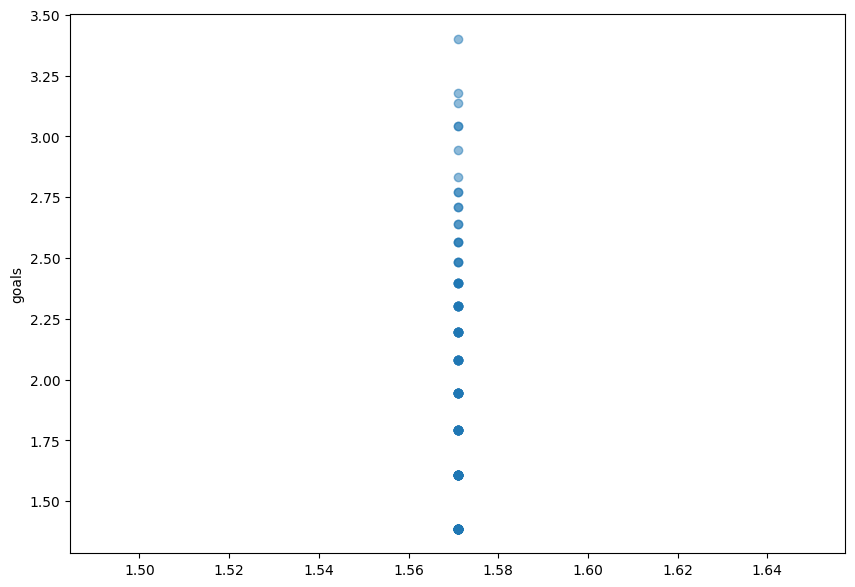

In [ ]:
plt.figure(figsize=(10, 7))

ax = sns.regplot(
    x=y_pred2425,
    y=y_test,
    ci=False,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red', 'linestyle': '--', 'linewidth': 2}
)

In [ ]:
residulas2425 = y_test - y_pred2425

<Axes: xlabel='goals', ylabel='Count'>

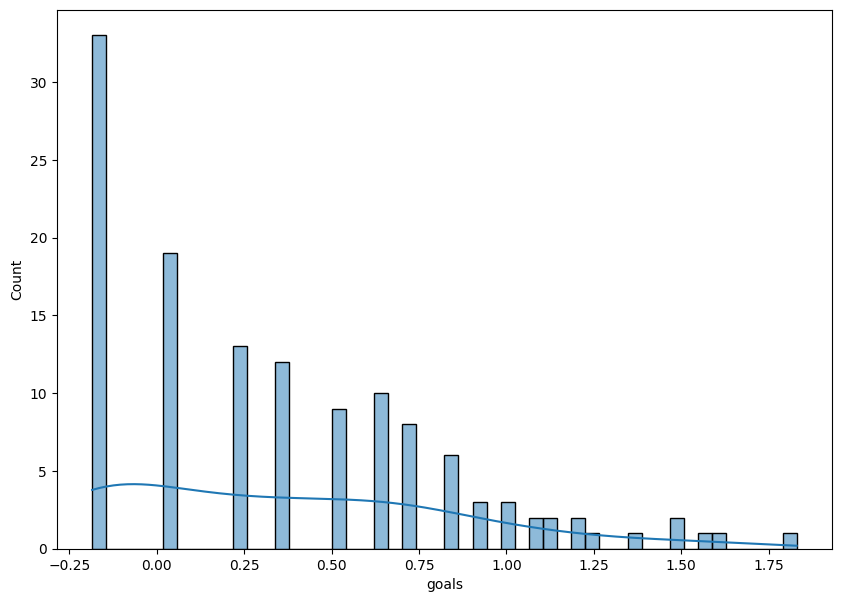

In [ ]:
plt.figure(figsize=(10, 7))
sns.histplot(
    data=residulas2425,
    bins=50,
    kde=True
)

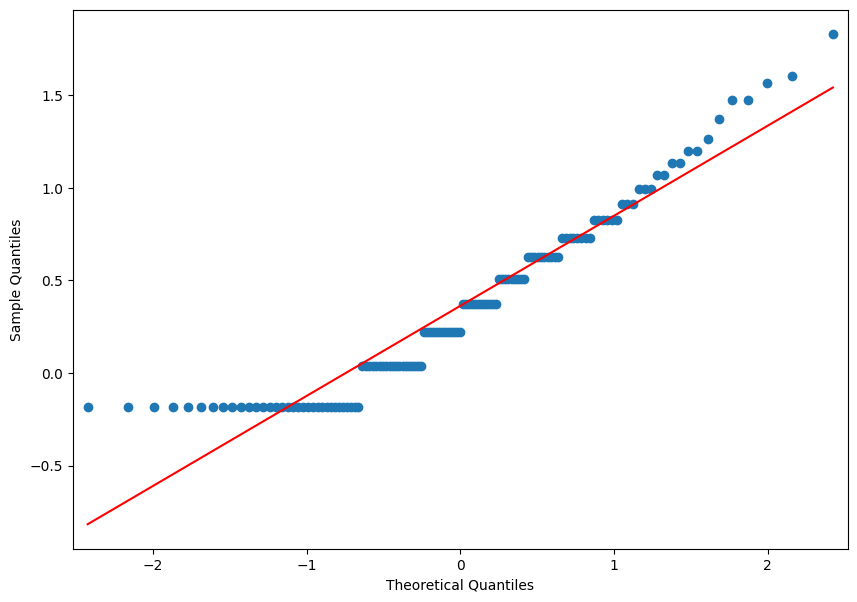

In [ ]:
sm.qqplot(residulas2425, line='s').set_size_inches(10, 7)

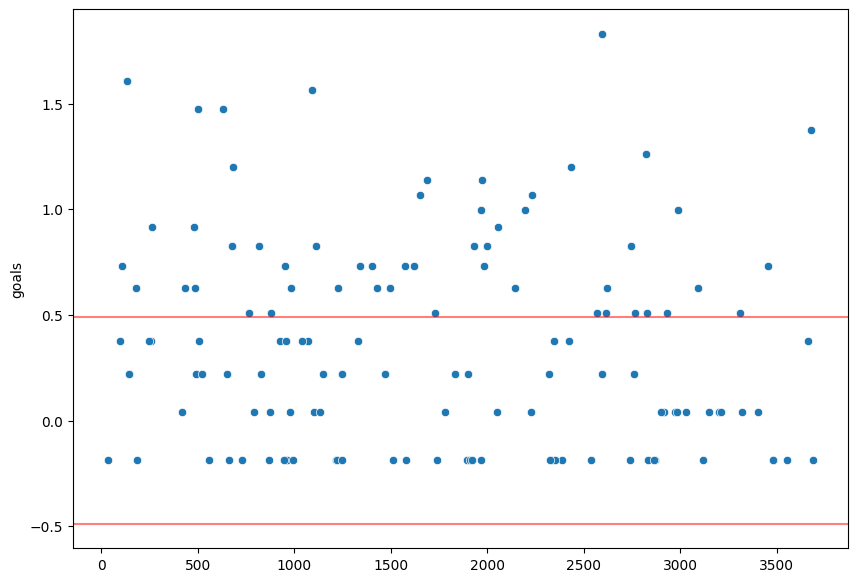

In [ ]:
plt.figure(figsize=(10, 7))
ax =sns.scatterplot(
    residulas2425
)
ax.axhline(y=residulas2425.std(), color="r", alpha=0.5)
ax.axhline(y=-residulas2425.std(), color="r", alpha=0.5)


In [ ]:
top_scorers_2526 = df[df.season==2526][["player", "goals"]]
top_scorers_2526.sort_values(by="goals", ascending=False).head(10)

,player,goals
1091,erling haaland,14.0
3384,thiago,8.0
817,danny welbeck,6.0
266,antoine semenyo,6.0
1687,jean-philippe mateta,6.0
501,bryan mbeumo,5.0
1518,jaidon anthony,4.0
3545,viktor gyokeres,4.0
3643,wilson isidor,4.0
2738,nick woltemade,4.0


In [ ]:
train = df['season'].isin([2526])

X_case1_train = df[train][case_1]
X_case2_train = df[train][case_2]

y_train = df[train]['goals']

In [ ]:
df11 = df.copy()

In [ ]:
df11['goals_11'] = (df11['goals']/ df11['matches'].replace(0, np.nan)).fillna(0) * 11
df11['xg_11'] = (df11['xg'] / df11['matches'].replace(0, np.nan)).fillna(0) * 11
df11['np_goals_11'] = (df11['np_goals'] / df11['matches'].replace(0, np.nan)).fillna(0) * 11
df11['np_xg_11'] = (df11['np_xg'] / df11['matches'].replace(0, np.nan)).fillna(0) * 11

df11['assists_11'] = (df11['assists'] / df11['matches'].replace(0, np.nan)).fillna(0) * 11
df11['xa_11'] = (df11['xa'] / df11['matches'].replace(0, np.nan)).fillna(0) * 11

df11['shots_11'] = (df11['shots'] / df11['matches'].replace(0, np.nan)).fillna(0) * 11
df11['key_passes_11'] = (df11['key_passes'] / df11['matches'].replace(0, np.nan)).fillna(0) * 11

df11['minutes_11'] = (df11['minutes'] / df11['matches'].replace(0, np.nan)).fillna(0) * 11

df11['yellow_11'] = (df11['yellow_cards'] / df11['matches'].replace(0, np.nan)).fillna(0) * 11
df11['red_11'] = (df11['red_cards'] / df11['matches'].replace(0, np.nan)).fillna(0) * 11

df11['xg_chain_11'] = (df11['xg_chain'] / df11['matches'].replace(0, np.nan)).fillna(0) * 11
df11['xg_buildup_11'] = (df11['xg_buildup'] / df11['matches'].replace(0, np.nan)).fillna(0) * 11


In [ ]:
y = df11.goals
y_train = y[train].apply(np.log1p)


In [ ]:
X_2526 = df[df.season==2526]
X_2526_case1 = X_2526[case_1]
X_2526_case2 = X_2526[case_2]


In [ ]:
rf_case1.fit(X_case1_train, y_train)
cat_case1.fit(X_case1_train, y_train)
lr_pipe_case1.fit(X_case1_train, y_train);


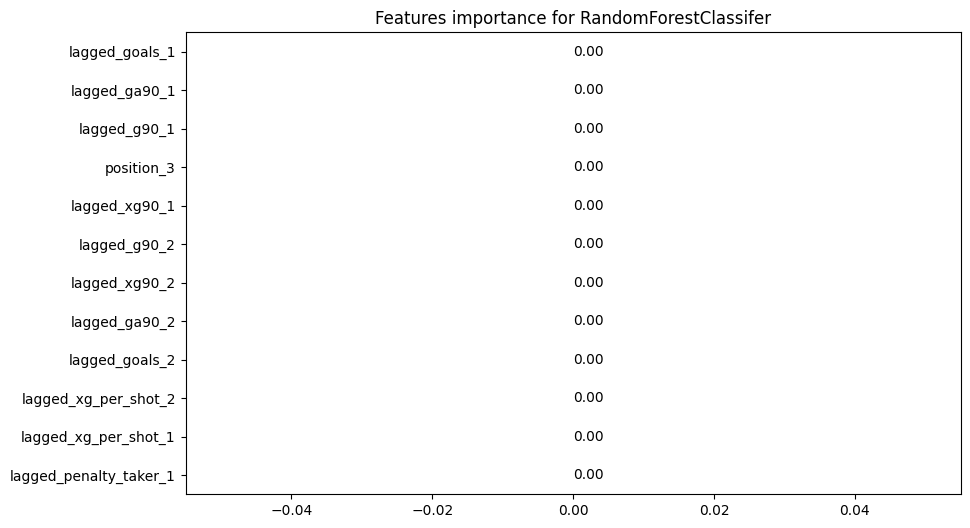

In [ ]:
best_features = pd.Series(rf_case1.feature_importances_, index=df[case_1].columns)

plt.figure(figsize=(10, 6))
ax=sns.barplot(data= best_features.sort_values(ascending=False),
            orient="h",
            estimator="sum",
            errorbar=None)
ax.bar_label(ax.containers[0], fontsize=10, fmt="%.2f");
plt.title("Features importance for RandomForestClassifer");

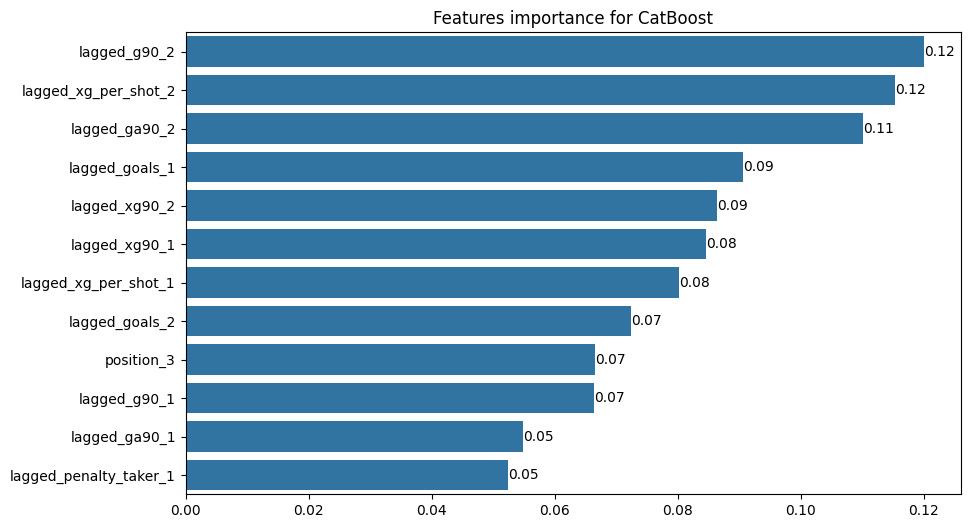

In [ ]:
best_features = pd.Series(cat_case1.feature_importances_/100, index=df[case_1].columns)

plt.figure(figsize=(10, 6))
ax=sns.barplot(data= best_features.sort_values(ascending=False),
            orient="h",
            estimator="sum",
            errorbar=None)
ax.bar_label(ax.containers[0], fontsize=10, fmt="%.2f");
plt.title("Features importance for CatBoost");

In [ ]:
y_pred_rf = pd.Series(rf_case1.predict(X_2526_case1), name="rf_predictions", index = X_2526.index).apply(np.expm1)
y_pred_cat = pd.Series(cat_case1.predict(X_2526_case1), name="cat_predictions", index = X_2526.index).apply(np.expm1)
y_pred_lr = pd.Series(lr_pipe_case1.predict(X_2526_case1), name="lasso_predictions", index = X_2526.index).apply(np.expm1)


In [ ]:
pd.concat([X_2526.player, y_pred_rf], axis=1).sort_values(by="rf_predictions", ascending=False).head(10).reset_index(drop=True).drop(columns="rf_predictions", axis=1)

,player
0,bukayo saka
1,viktor gyokeres
2,donyell malen
3,emiliano buendía
4,antoine semenyo
5,eli junior kroupi
6,kevin schade
7,thiago
8,danny welbeck
9,jaidon anthony


In [ ]:
pd.concat([X_2526.player, y_pred_cat], axis=1).sort_values(by="cat_predictions", ascending=False).head(10).reset_index(drop=True).drop(columns="cat_predictions", axis=1)

,player
0,erling haaland
1,thiago
2,jean-philippe mateta
3,danny welbeck
4,antoine semenyo
5,bryan mbeumo
6,mohamed salah
7,joão pedro
8,viktor gyokeres
9,nick woltemade


In [ ]:
pd.concat([X_2526.player, y_pred_lr], axis=1).sort_values(by="lr_predictions", ascending=False).head(10).reset_index(drop=True).drop(columns="lr_predictions", axis=1)

KeyError: 'lr_predictions'